In [65]:
import warnings
warnings.filterwarnings("ignore")

In [66]:
from matplotlib import pyplot as plt
import numpy as np
import random
import tensorflow as tf
import fix_yahoo_finance as yf 
from datetime import datetime
import time
import copy
import pandas as pd
import altair as alt
import seaborn as sns

In [67]:
def plot_prices(train_prices, test_prices=None):
    plt.xlabel('time')
    plt.ylabel('price')
    plt.plot(range(len(train_prices)), train_prices, 'b')
    if test_prices is not None:
        plt.plot(range(len(train_prices), len(train_prices) + len(test_prices)), test_prices, 'g')
    plt.show()

[*********************100%***********************]  1 of 1 downloaded


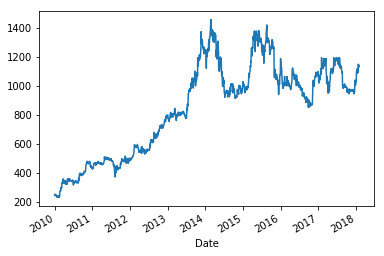

In [68]:
data = yf.download('WWL','2010-01-01','2019-03-01')
data.Close.plot()
plt.show()

In [69]:
df = yf.download('WWL','2010-01-01','2019-03-01')
df.index.name = 'Date'
df.reset_index(inplace=True)
# filter out the desired features
df = df[['Date', 'Adj Close']]
# rename feature column names
df = df.rename(columns={'Adj Close': 'actual', 'Date': 'date'})
# convert dates from object to DateTime type
dates = df['date']
dates = pd.to_datetime(dates, infer_datetime_format=True)
df['date'] = dates

[*********************100%***********************]  1 of 1 downloaded


In [70]:
class DecisionPolicy:
    # A Given a state, the decision policy will calculate the next action to take
    def select_action(self, current_state): 
        pass
    # Improve the Q-function from a new experience of taking an action
    def update_q(self, state, action, reward, next_state): 
        pass

In [71]:
class RandomDecisionPolicy(DecisionPolicy):
    # Inherit from DecisionPolicy to implement its functions
    def __init__(self, actions):
        self.actions = actions
    # Randomly choose the next action
    def select_action(self, current_state, step):
        action = random.choice(self.actions)
        return action

In [72]:
class QLearningDecisionPolicy(DecisionPolicy):
    # Set the hyper-parameters from the Q-function. 
    # To keep the solution from getting “stuck” when applying the same action over and over.
    # The lesser the epsilon value, the more often it will randomly explore new actions.
    def __init__(self, actions, input_dim):
        self.epsilon = 0.95
        self.gamma = 0.5
        self.actions = actions
        output_dim = len(actions) # output dimentions
        h1_dim = 20 # Set the number of hidden nodes in the neural networks

        self.x = tf.placeholder(tf.float32, [None, input_dim]) # input vector
        self.y = tf.placeholder(tf.float32, [output_dim]) # output vector
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim])) # weights from input to hidden 
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim])) # biases from input to hidden
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1) # hidden layer vector
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim])) # weights from hidden to output
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim])) # biases from hidden to output
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2) # output of neural network
        
        # Set loss as a squared error and use an optimizer
        loss = tf.square(self.y - self.q)
        self.train_op = tf.train.AdamOptimizer(0.001).minimize(loss)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 1000.)
        if random.random() < threshold:
            # Exploit best option with probability epsilon
            action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
            action_idx = np.argmax(action_q_vals)  # TODO: replace w/ tensorflow's argmax
            action = self.actions[action_idx]
        else:
            # Explore random option with probability 1 - epsilon
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action

    # Update the Q-function by updating its model parameters
    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        current_action_idx = self.actions.index(action)
        action_q_vals[0, current_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y: action_q_vals})

In [73]:
def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist, learn=True):
    # Initialize values that depend on computing the net worth of a portfolio
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    history = []
    portfolio_history = []
    for i in range(len(prices) - hist - 1):
        if i % 1000 == 0:
            print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
        # The state is a `hist+2` dimensional vector. We’ll force it to by a numpy matrix.
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        # Calculate the portfolio value
        current_portfolio = budget + num_stocks * share_value
        # Select an action from the current policy
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + hist])
        # Update portfolio values based on action
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
            history.append((prices[i], 'BUY'))
            portfolio_history.append((current_portfolio, 'BUY'))
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
            history.append((prices[i],'SELL'))
            portfolio_history.append((current_portfolio,'SELL'))
        else:
            action = 'Hold'
            history.append((prices[i], 'HOLD'))
            portfolio_history.append((current_portfolio, 'HOLD'))
        
        # Compute new portfolio value after taking action
        new_portfolio = budget + num_stocks * share_value
        if learn:
            reward = new_portfolio - current_portfolio
            next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))
            transitions.append((current_state, action, reward, next_state))
            policy.update_q(current_state, action, reward, next_state)

    # Compute final portfolio worth
    portfolio = budget + num_stocks * share_value
    return portfolio, history, portfolio_history

In [74]:
def run_simulations(policy, budget, num_stocks, prices, hist):
    # Decide number of times to re-run the simulations
    num_tries = 5
    # Store portfolio worth of each run in this array
    final_portfolios = list()
    # Run this simulation
    #for _ in range(num_tries):
    #    portfolio, history, portfolio_history = run_simulation(policy, budget, num_stocks, prices, hist)
    #    final_portfolios.append(portfolio)
    #    print('Final portfolio: ${}'.format(portfolio))      
    #plt.title('Final Portfolio Value')
    #plt.xlabel('Epochs')
    #plt.ylabel('Training Portfolio Value')
    #plt.plot(final_portfolios)
    #plt.show()

In [75]:
if __name__ == "__main__":    
    tf.reset_default_graph()
    prices = data.Close
    n = len(prices)
    n_train = int(n * 0.25)
    train_prices = prices[:n_train]
    test_prices = prices[n_train:]
    #print(train_prices)
    #print(test_prices)
    #plot_prices(train_prices, test_prices)

    # Define the list of actions the agent can take
    actions = ['Buy', 'Sell', 'Hold']
    hist = 200
    # Initial a decision policy
    policy = QLearningDecisionPolicy(actions, hist + 2)
    # Set the initial amount of money available to use
    budget = 1000.0
    # Set the number of stocks already owned
    num_stocks = 0
    # Run simulations multiple times to compute expected value of final net worth
    run_simulations(policy, budget, num_stocks, train_prices, hist)

    # Exacute on test set
    portfolio, history, portfolio_history = run_simulation(policy, budget, num_stocks, test_prices, hist, learn=False)
    print(portfolio)
    print( np.std([x[0] for x in portfolio_history]))

progress 0.00%
progress 76.45%
1661.1001569999999
224.5073617232231


In [76]:
if __name__ == "__main__":
    prices = data.Close
    n = len(prices)
    n_train = int(n * 0.25)
    train_prices = prices[:n_train]
    test_prices = prices[n_train:]
    #print(train_prices)
    #print(test_prices)
    #plot_prices(train_prices, test_prices)

    # Define the list of actions the agent can take
    actions = ['Buy', 'Hold', 'Sell']
    # Initial a decision policy
    policy = RandomDecisionPolicy(actions)
    # Set the initial amount of money available to use
    budget = 1000.0
    # Set the number of stocks already owned
    num_stocks = 0
    # Run simulations multiple times to compute expected value of final net worth
    run_simulation(policy, budget, num_stocks, train_prices, hist)

    # Exacute on test set
    portfolio_rand, history_rand, portfolio_history_rand = run_simulation(policy, budget, num_stocks, test_prices, hist, learn=False)
    print(portfolio_rand)
    print(np.std([x[0] for x in portfolio_history_rand]))

progress 0.00%
progress 0.00%
progress 76.45%
1442.4998770000016
108.26889616832723


In [77]:
if __name__ == "__main__":
    prices = data.Close
    n = len(prices)
    n_train = int(n * 0.25)
    train_prices = prices[:n_train]
    test_prices = prices[n_train:]
    #print(train_prices)
    #print(test_prices)
    #plot_prices(train_prices, test_prices)

    # Define the list of actions the agent can take
    actions = ['Buy', 'Hold', 'Hold']
    # Initial a decision policy
    policy = RandomDecisionPolicy(actions)
    # Set the initial amount of money available to use
    budget = 1000.0
    # Set the number of stocks already owned
    num_stocks = 0
    # Run simulations multiple times to compute expected value of final net worth
    run_simulation(policy, budget, num_stocks, train_prices, hist)

    # Exacute on test set
    portfolio_bh, history_bh, portfolio_history_bh = run_simulation(policy, budget, num_stocks, test_prices, hist, learn=True)
    print(portfolio_bh)
    print(np.std([x[0] for x in portfolio_history_bh]))

progress 0.00%
progress 0.00%
progress 76.45%
1394.0
163.35898788143172


In [78]:
test_prices_plot = pd.DataFrame(test_prices)
test_prices_plot.index.name = 'Date'
test_prices_plot.reset_index(inplace=True)


# filter out the desired features
test_prices_plot = test_prices_plot[['Date', 'Close']]
# rename feature column names
test_prices_plot = test_prices_plot.rename(columns={'Close': 'actual', 'Date': 'date'})
# convert dates from object to DateTime type
dates = test_prices_plot['date']
dates = pd.to_datetime(dates, infer_datetime_format=True)
test_prices_plot['date'] = dates
test_prices_plot = test_prices_plot[hist:]

In [79]:
def visualize(df, history):
    # add history to dataframe
    position = [history[0][0]] + [x[0] for x in history]
    actions = ['HOLD'] + [x[1] for x in history]
    df['position'] = position
    df['action'] = actions
    
    # specify y-axis scale for stock prices
    scale = alt.Scale(domain=(min(min(df['actual']), min(df['position'])) - 50, max(max(df['actual']), max(df['position'])) + 50), clamp=True)
    
    # plot a line chart for stock positions
    actual = alt.Chart(df).mark_line(
        color='black',
        opacity=0.2
    ).encode(
        x='date:T',
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale)
    ).interactive(
        bind_y=False
    )
    
    # plot the BUY and SELL actions as points
    points = alt.Chart(df).transform_filter(
        alt.datum.action != 'HOLD'
    ).mark_point(
        filled=True
    ).encode(
        x=alt.X('date:T', axis=alt.Axis(title='Date')),
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale),
        color='action'
        #color=alt.Color('action', scale=alt.Scale(range=['blue', 'green', 'red']))
    ).interactive(bind_y=False)

    # merge the two charts
    chart = alt.layer(actual, points, title="Portfolio Actions").properties(height=300, width=1000)
    
    return chart

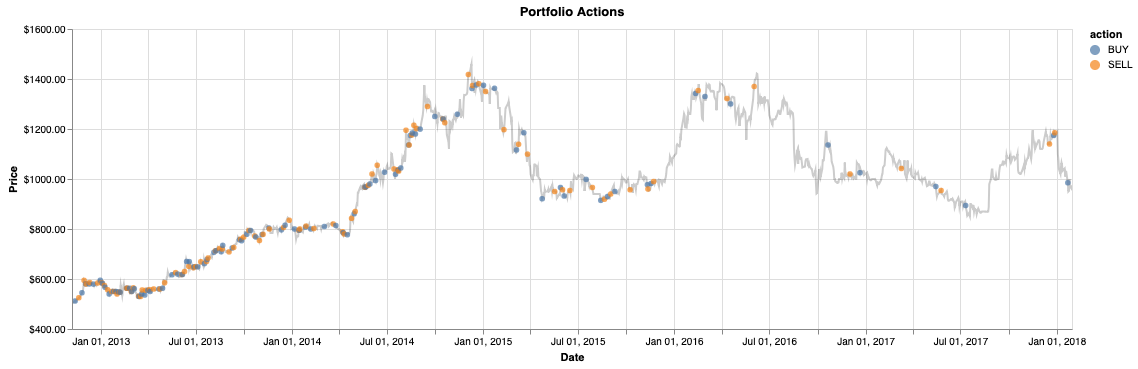

In [80]:
chart = visualize(test_prices_plot, history)
chart

In [81]:
def visualize2(df, history, portfolio_history, portfolio_history_rand, portfolio_history_bh):
    # add history to dataframe
    position = [history[0][0]] + [x[0] for x in history]
    portfolio_history =  [portfolio_history[0][0]] + [x[0] for x in portfolio_history]
    portfolio_history_rand =  [portfolio_history_rand[0][0]] + [x[0] for x in portfolio_history_rand]
    portfolio_history_bh =  [portfolio_history_bh[0][0]] + [x[0] for x in portfolio_history_bh]
    actions = ['HOLD'] + [x[1] for x in history]
    df['position'] = position
    df['action'] = actions
    df['portfolio_history'] = portfolio_history
    df['portfolio_history_rand'] = portfolio_history_rand
    df['portfolio_history_bh'] = portfolio_history_bh
    
    
    # specify y-axis scale for stock prices
    scale = alt.Scale(domain=(min(min(df['portfolio_history_bh']), min(df['portfolio_history'])) - 50, max(max(df['portfolio_history_bh']), max(df['portfolio_history'])) + 50), clamp=True)
    
    
    # plot a line chart for stock positions
    actual = alt.Chart(df).mark_line(
        color='green',
        opacity=0.5
    ).encode(
        y=alt.Y('portfolio_history', axis=alt.Axis(format='$.2f', title='Portfolio Value'), scale=scale),
        x=alt.X('date:T', axis=alt.Axis(title='Date'))
    ).interactive(
        bind_y=False
    )
    
      # plot a line chart for stock positions
    actual_rand = alt.Chart(df).mark_line(
        color='blue',
        opacity=0.5
    ).encode(
        x='date:T',
        y=alt.Y('portfolio_history_rand', axis=alt.Axis(format='$.2f', title='Portfolio Value'))
    ).interactive(
        bind_y=False
    )
    
    
      # plot a line chart for stock positions
    actual_bh = alt.Chart(df).mark_line(
        color='red',
        opacity=0.5
    ).encode(
        x='date:T',
        y=alt.Y('portfolio_history_bh', axis=alt.Axis(format='$.2f', title='Portfolio Value'))
    ).interactive(
        bind_y=False
    )
    
    # merge the two charts
    chart = alt.layer(actual,actual_rand,actual_bh, title="Portfolio Value").properties(height=300, width=1000)
    
    return chart

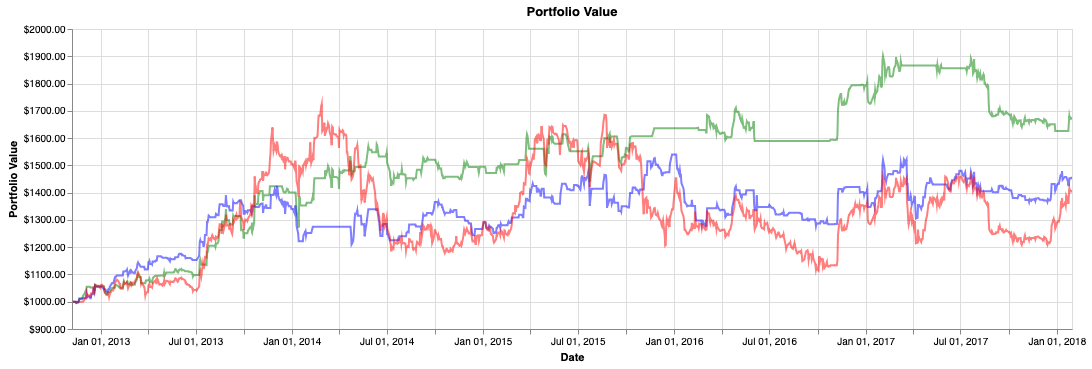

In [82]:
chart1 = visualize2(test_prices_plot, history, portfolio_history, portfolio_history_rand, portfolio_history_bh)
chart1